# Tulsa Government Access Television Meetings

This notebook demonstrates how to fetch meeting data from the Tulsa Government Access Television website and convert it to a pandas DataFrame for analysis.

In [12]:
import sys
import os
from pathlib import Path
import asyncio
import pandas as pd
from IPython.display import display

sys.path.append("../")

print("Python path:")
for p in sys.path:
    print(f"  {p}")

from src.meetings import get_meetings

Python path:
  /Users/owner/.pyenv/versions/3.10.3/lib/python310.zip
  /Users/owner/.pyenv/versions/3.10.3/lib/python3.10
  /Users/owner/.pyenv/versions/3.10.3/lib/python3.10/lib-dynload
  
  /Users/owner/Library/Caches/pypoetry/virtualenvs/tgov_scraper-zRR99ne3-py3.10/lib/python3.10/site-packages
  ../
  ../
  ../


## Fetch Meeting Data

First, let's fetch the meeting data from the TGOV website using our `get_meetings()` function.

In [13]:

# Fetch the meetings
meetings = await get_meetings()

# Display the first few meetings
print(f"Found {len(meetings)} meetings")
meetings[:5]

Found 2384 meetings


[Meeting(meeting='Regular Council Meeting', date='March\xa0 5,\xa02025\n                                                                                                                                      -\n                                                                                               5:02\xa0PM', duration='00h\xa039m', agenda=HttpUrl('https://tulsa-ok.granicus.com/AgendaViewer.php?view_id=4&clip_id=6412'), video=HttpUrl('https://tulsa-ok.granicus.com/MediaPlayer.php?view_id=4&clip_id=6412')),
 Meeting(meeting='Regular Council Meeting', date='February\xa026,\xa02025\n                                                                                                                                      -\n                                                                                               5:00\xa0PM', duration='00h\xa038m', agenda=HttpUrl('https://tulsa-ok.granicus.com/AgendaViewer.php?view_id=4&clip_id=6399'), video=HttpUrl('https://tulsa-ok.granicus.com/MediaP

## Convert to DataFrame

Now, let's convert the list of Meeting objects to a pandas DataFrame for easier analysis.

In [14]:
# Convert Meeting objects to dictionaries
meeting_dicts = [meeting.model_dump() for meeting in meetings]

# Create a DataFrame
df = pd.DataFrame(meeting_dicts)

# Display the DataFrame
display(df.head())
print(f"DataFrame shape: {df.shape}")

,meeting,date,duration,agenda,video
0,Regular Council Meeting,"March 5, 2025\n ...",00h 39m,https://tulsa-ok.granicus.com/AgendaViewer.php...,https://tulsa-ok.granicus.com/MediaPlayer.php?...
1,Regular Council Meeting,"February 26, 2025\n ...",00h 38m,https://tulsa-ok.granicus.com/AgendaViewer.php...,https://tulsa-ok.granicus.com/MediaPlayer.php?...
2,Regular Council Meeting,"February 12, 2025\n ...",00h 31m,https://tulsa-ok.granicus.com/AgendaViewer.php...,https://tulsa-ok.granicus.com/MediaPlayer.php?...
3,Regular Council Meeting,"February 5, 2025\n ...",00h 29m,https://tulsa-ok.granicus.com/AgendaViewer.php...,https://tulsa-ok.granicus.com/MediaPlayer.php?...
4,Regular Council Meeting,"January 29, 2025\n ...",01h 13m,https://tulsa-ok.granicus.com/AgendaViewer.php...,https://tulsa-ok.granicus.com/MediaPlayer.php?...


DataFrame shape: (2384, 5)


## Basic Analysis

Let's perform some basic analysis on the meeting data.

meeting
Regular Council Meeting                           299
Council Public Works Committee                    240
Council Urban & Economic Development Committee    216
Board of Adjustment                               205
Tulsa Metropolitan Area Planning Commission       193
                                                 ... 
Special Meeting Part 1                              1
Council Special Meeting Part 2                      1
Council Special Meeting Part 1                      1
Housing and Urban Development                       1
Vision/Economic Development Task force              1
Name: count, Length: 81, dtype: int64

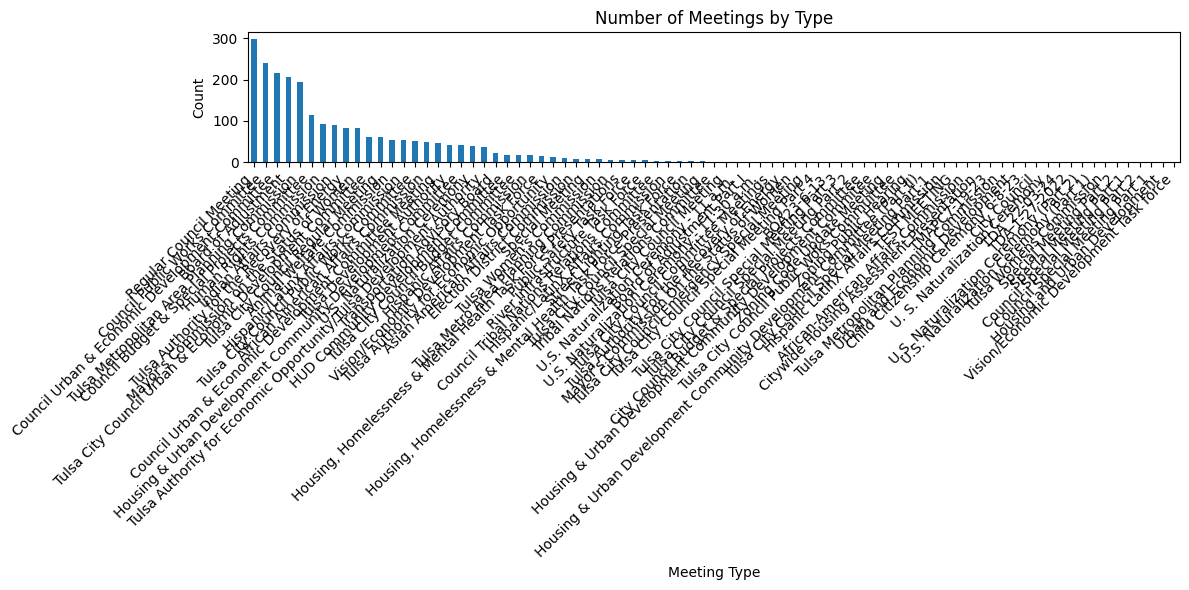

In [15]:
import matplotlib.pyplot as plt

# Count meetings by type
meeting_counts = df['meeting'].value_counts()
display(meeting_counts)

# Plot the meeting counts
meeting_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Meetings by Type')
plt.xlabel('Meeting Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Duration Analysis

Let's analyze the duration of meetings.

count    2384.000000
mean       98.416527
std        69.858335
min         0.000000
25%        50.000000
50%        81.000000
75%       120.000000
max       480.000000
Name: duration_minutes, dtype: float64

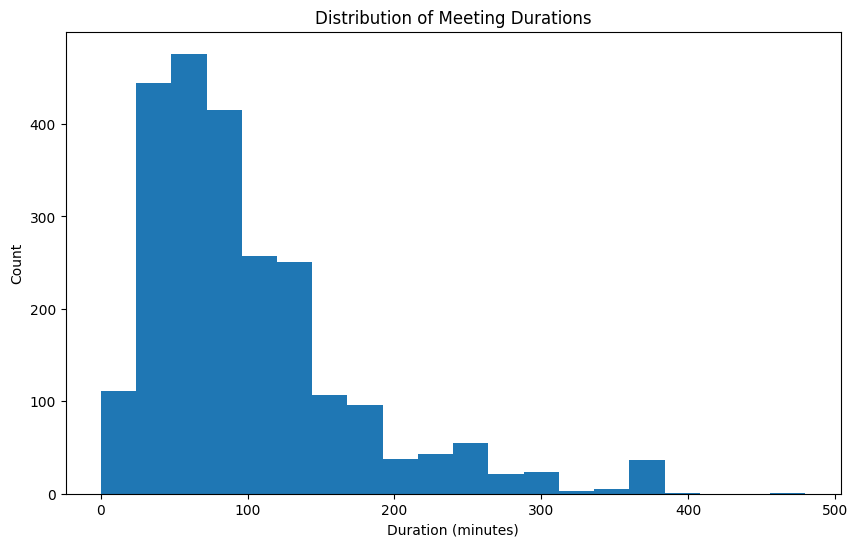

In [16]:
# Convert duration strings to minutes
def duration_to_minutes(duration):
    if not duration or pd.isna(duration):
        return None
    
    # Parse duration in format "00h 39m"
    try:
        hours = 0
        minutes = 0
        
        if 'h' in duration:
            hours_part = duration.split('h')[0].strip()
            hours = int(hours_part)
        
        if 'm' in duration:
            if 'h' in duration:
                minutes_part = duration.split('h')[1].split('m')[0].strip()
            else:
                minutes_part = duration.split('m')[0].strip()
            minutes = int(minutes_part)
        
        return hours * 60 + minutes
    except:
        return None

# Apply the conversion
df['duration_minutes'] = df['duration'].apply(duration_to_minutes)

# Display statistics about meeting durations
duration_stats = df['duration_minutes'].describe()
display(duration_stats)

# Plot a histogram of meeting durations
plt.figure(figsize=(10, 6))
df['duration_minutes'].hist(bins=20)
plt.title('Distribution of Meeting Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.grid(False)
plt.show()

## Average Duration by Meeting Type

Let's calculate the average duration for each type of meeting.

meeting
Board of Adjustment Part I                                              297.000000
Tulsa City Council Committee Meetings                                   294.000000
Tulsa Authority for Economic Opportunity/Tulsa Development Authority    269.945946
Tulsa City Council Special Meeting                                      204.666667
Council Tribal Nations Relations Committee                              180.000000
                                                                           ...    
U. S. Naturalization Ceremony                                            24.000000
U.S. Naturalization Ceremony - 11:30 a.m.                                23.500000
Housing, Homelessness & Mental Health Task Force Presentation            15.750000
U.S. Naturalization Ceremony (Part 2)                                    14.000000
TEST MEETING                                                              0.000000
Name: duration_minutes, Length: 81, dtype: float64

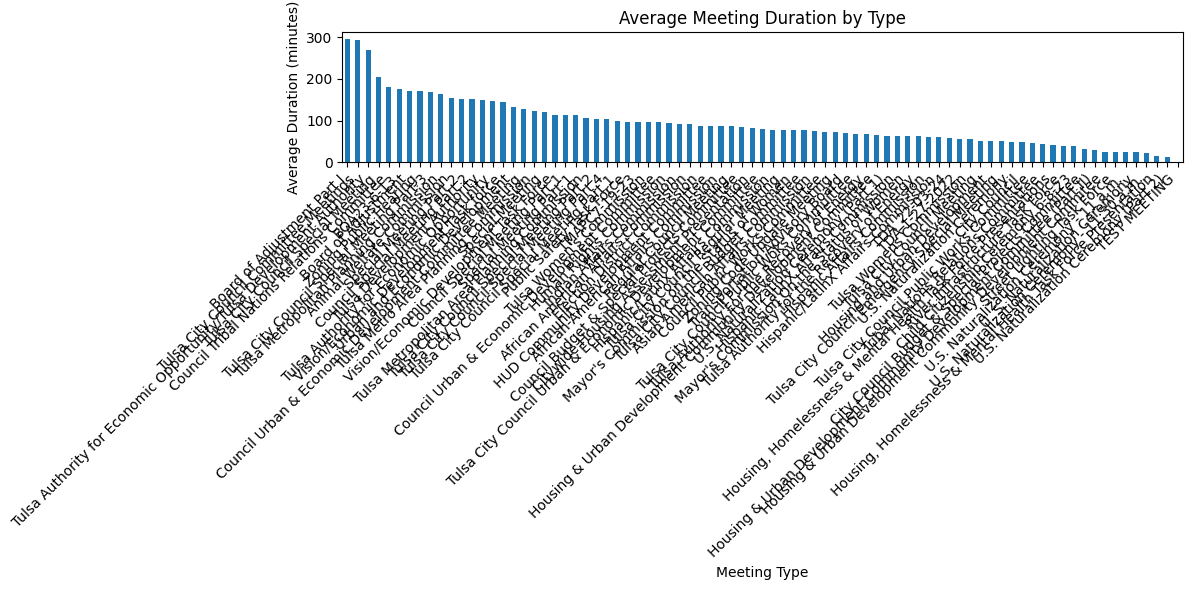

In [17]:
# Group by meeting type and calculate average duration
avg_duration_by_type = df.groupby('meeting')['duration_minutes'].mean().sort_values(ascending=False)
display(avg_duration_by_type)

# Plot the average durations
avg_duration_by_type.plot(kind='bar', figsize=(12, 6))
plt.title('Average Meeting Duration by Type')
plt.xlabel('Meeting Type')
plt.ylabel('Average Duration (minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Save the DataFrame

Finally, let's save the DataFrame to a CSV file for future use.

In [18]:
df.head()

,meeting,date,duration,agenda,video,duration_minutes
0,Regular Council Meeting,"March 5, 2025\n ...",00h 39m,https://tulsa-ok.granicus.com/AgendaViewer.php...,https://tulsa-ok.granicus.com/MediaPlayer.php?...,39
1,Regular Council Meeting,"February 26, 2025\n ...",00h 38m,https://tulsa-ok.granicus.com/AgendaViewer.php...,https://tulsa-ok.granicus.com/MediaPlayer.php?...,38
2,Regular Council Meeting,"February 12, 2025\n ...",00h 31m,https://tulsa-ok.granicus.com/AgendaViewer.php...,https://tulsa-ok.granicus.com/MediaPlayer.php?...,31
3,Regular Council Meeting,"February 5, 2025\n ...",00h 29m,https://tulsa-ok.granicus.com/AgendaViewer.php...,https://tulsa-ok.granicus.com/MediaPlayer.php?...,29
4,Regular Council Meeting,"January 29, 2025\n ...",01h 13m,https://tulsa-ok.granicus.com/AgendaViewer.php...,https://tulsa-ok.granicus.com/MediaPlayer.php?...,73


In [19]:
# Save to CSV
output_path = '../data/meetings.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"DataFrame saved to {output_path}")

DataFrame saved to ../data/meetings.csv
